<h1 style="text-align: center;">Sequence Labeling<h1>

Prepare libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from camel_tools.tokenizers.morphological import MorphologicalTokenizer
from camel_tools.disambig.mle import MLEDisambiguator
import re
import nltk
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer 
from sklearn.calibration import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
import numpy as np
import sklearn_crfsuite
from sklearn_crfsuite import metrics


# Question [1]: Data Preparation

## [1.1]

In [2]:
df = pd.read_csv('IOB.csv', encoding='utf-8')


def create_data_tuples(df):
    data_tuples = list(df[['Word i', 'Word i entity tag']].itertuples(index=False, name=None))
    return data_tuples


data_tuples = create_data_tuples(df)
data_tuples[:10]

[('إن', 'O'),
 ('اللوكيميا', 'B'),
 ('أو', 'O'),
 ('(', 'O'),
 ('ابيضاض', 'B'),
 ('الدم', 'I'),
 (')', 'O'),
 ('هو', 'O'),
 ('سرطان', 'B'),
 ('خلايا', 'I')]

## [1.2]

In [3]:
def extract_sentences(df):
    sentences = []
    current_sentence = []

    for index, row in df.iterrows():
        current_sentence.append(row['Word i'])

        if row['Word i'].endswith('.'):
            sentences.append(current_sentence)
            current_sentence = []

    if current_sentence:
        sentences.append(current_sentence)

    return sentences


sentences = extract_sentences(df)

sentences[:10]


[['إن',
  'اللوكيميا',
  'أو',
  '(',
  'ابيضاض',
  'الدم',
  ')',
  'هو',
  'سرطان',
  'خلايا',
  'الدم',
  'البيضاء',
  ',',
  'و',
  'خلايا',
  'الدم',
  'البيضاء',
  'تساعد',
  'الجسم',
  'على',
  'محاربة',
  'العدوى',
  '.'],
 ['تتشكل',
  'خلايا',
  'الدم',
  'في',
  'نقي',
  'العظام',
  ',',
  'أما',
  'في',
  'اللوكيميا',
  'ف',
  'يقوم',
  'نقي',
  'العظام',
  'على',
  'كل',
  'حال',
  'ب',
  'إنتاج',
  'خلايا',
  'دم',
  'بيضاء',
  'غير',
  'طبيعية',
  ',',
  'ب',
  'حيث',
  'تتجمع',
  'تلك',
  'الخلايا',
  'حول',
  'خلايا',
  'الدم',
  'الصحيحة',
  'مما',
  'يجعل',
  'من',
  'الصعب',
  'أن',
  'تقوم',
  'هذه',
  'الخلايا',
  'ب',
  'عملها',
  'ب',
  'شكل',
  'عادي',
  '.'],
 ['هناك',
  'أنواع',
  'مختلفة',
  'من',
  'اللوكيميا',
  ',',
  'و',
  'تتضمن',
  'هذه',
  'الأنواع',
  ':',
  'ابيضاض',
  'اللمفاويات',
  'الحاد',
  'الابيضاض',
  'النخاعي',
  'الحاد',
  'ابيضاض',
  'اللمفاويات',
  'المزمن',
  'الابيضاض',
  'النخاعي',
  'المزمن',
  'يمكن',
  'ل',
  'اللوكيميا',
  'أن',
 

## [1.3]

In [4]:

def extract_sentences_with_entities(df):
    sentences = []
    current_sentence = []

    for _, row in df.iterrows():
        word_entity_tuple = (row['Word i'], row['Word i entity tag'])
        current_sentence.append(word_entity_tuple)

        if row['Word i'].endswith('.') or _ == len(df) - 1:
            sentences.append(current_sentence)
            current_sentence = []

    return sentences


sentences = extract_sentences_with_entities(df)
sentences[:5]


[[('إن', 'O'),
  ('اللوكيميا', 'B'),
  ('أو', 'O'),
  ('(', 'O'),
  ('ابيضاض', 'B'),
  ('الدم', 'I'),
  (')', 'O'),
  ('هو', 'O'),
  ('سرطان', 'B'),
  ('خلايا', 'I'),
  ('الدم', 'I'),
  ('البيضاء', 'I'),
  (',', 'O'),
  ('و', 'O'),
  ('خلايا', 'O'),
  ('الدم', 'O'),
  ('البيضاء', 'O'),
  ('تساعد', 'O'),
  ('الجسم', 'O'),
  ('على', 'O'),
  ('محاربة', 'O'),
  ('العدوى', 'O'),
  ('.', 'O')],
 [('تتشكل', 'O'),
  ('خلايا', 'O'),
  ('الدم', 'O'),
  ('في', 'O'),
  ('نقي', 'O'),
  ('العظام', 'O'),
  (',', 'O'),
  ('أما', 'O'),
  ('في', 'O'),
  ('اللوكيميا', 'B'),
  ('ف', 'O'),
  ('يقوم', 'O'),
  ('نقي', 'O'),
  ('العظام', 'O'),
  ('على', 'O'),
  ('كل', 'O'),
  ('حال', 'O'),
  ('ب', 'O'),
  ('إنتاج', 'O'),
  ('خلايا', 'O'),
  ('دم', 'O'),
  ('بيضاء', 'O'),
  ('غير', 'O'),
  ('طبيعية', 'O'),
  (',', 'O'),
  ('ب', 'O'),
  ('حيث', 'O'),
  ('تتجمع', 'O'),
  ('تلك', 'O'),
  ('الخلايا', 'O'),
  ('حول', 'O'),
  ('خلايا', 'O'),
  ('الدم', 'O'),
  ('الصحيحة', 'O'),
  ('مما', 'O'),
  ('يجعل', 'O'),
  ('م

## [1.4]

In [5]:
def extract_sentence_tokens_and_entities(df):
    sentence_tokens = []
    sentence_entities = []
    current_sentence_tokens = []
    current_sentence_entities = []

    for _, row in df.iterrows():
        current_sentence_tokens.append(row['Word i'])
        current_sentence_entities.append(row['Word i entity tag'])

        if row['Word i'].endswith('.') or _ == len(df) - 1:
            sentence_tokens.append(current_sentence_tokens)
            sentence_entities.append(current_sentence_entities)
            current_sentence_tokens = []
            current_sentence_entities = []

    return sentence_tokens, sentence_entities


sentence_tokens, sentence_entities = extract_sentence_tokens_and_entities(df)

print("List of sentence tokens:", sentence_tokens[:10])
print("List of sentence entity classifications:", sentence_entities[:10])


List of sentence tokens: [['إن', 'اللوكيميا', 'أو', '(', 'ابيضاض', 'الدم', ')', 'هو', 'سرطان', 'خلايا', 'الدم', 'البيضاء', ',', 'و', 'خلايا', 'الدم', 'البيضاء', 'تساعد', 'الجسم', 'على', 'محاربة', 'العدوى', '.'], ['تتشكل', 'خلايا', 'الدم', 'في', 'نقي', 'العظام', ',', 'أما', 'في', 'اللوكيميا', 'ف', 'يقوم', 'نقي', 'العظام', 'على', 'كل', 'حال', 'ب', 'إنتاج', 'خلايا', 'دم', 'بيضاء', 'غير', 'طبيعية', ',', 'ب', 'حيث', 'تتجمع', 'تلك', 'الخلايا', 'حول', 'خلايا', 'الدم', 'الصحيحة', 'مما', 'يجعل', 'من', 'الصعب', 'أن', 'تقوم', 'هذه', 'الخلايا', 'ب', 'عملها', 'ب', 'شكل', 'عادي', '.'], ['هناك', 'أنواع', 'مختلفة', 'من', 'اللوكيميا', ',', 'و', 'تتضمن', 'هذه', 'الأنواع', ':', 'ابيضاض', 'اللمفاويات', 'الحاد', 'الابيضاض', 'النخاعي', 'الحاد', 'ابيضاض', 'اللمفاويات', 'المزمن', 'الابيضاض', 'النخاعي', 'المزمن', 'يمكن', 'ل', 'اللوكيميا', 'أن', 'تتطور', 'ب', 'سرعة', 'أو', 'ب', 'بطء', ',', 'ف', 'اللوكيميا', 'المزمنة', 'تتطور', 'ب', 'بطء', ',', 'أما', 'في', 'اللوكيميا', 'الحادة', 'فتكون', 'الخلايا', 'شاذة', 'جدا

## [1.5]

In [6]:

def split_data_into_train_test(df, test_size=0.2, random_state=42):
    df['Sentence_ID'] = (df['Word i'].str.endswith('.')).shift(1, fill_value=True).cumsum()

    train_sentences, test_sentences = train_test_split(df['Sentence_ID'].unique(), test_size=test_size, random_state=random_state)
    train_data = df[df['Sentence_ID'].isin(train_sentences)]
    test_data = df[df['Sentence_ID'].isin(test_sentences)]
    train_data = train_data.drop(columns=['Sentence_ID'])
    test_data = test_data.drop(columns=['Sentence_ID'])

    return train_data, test_data, train_sentences, test_sentences

train_data, test_data, train_sentences, test_sentences = split_data_into_train_test(df)


In [7]:
df.head(30)

,Word i,Word i entity tag,Word i POS,Stopword,Sentence_ID
0,إن,O,verb_pseudo,yes,1
1,اللوكيميا,B,noun,no,1
2,أو,O,conj,yes,1
3,(,O,punc,no,1
4,ابيضاض,B,noun,no,1
5,الدم,I,noun,no,1
6,),O,punc,no,1
7,هو,O,pron,yes,1
8,سرطان,B,noun,no,1
9,خلايا,I,noun,no,1


In [8]:
train_data.head()

,Word i,Word i entity tag,Word i POS,Stopword
23,تتشكل,O,verb,no
24,خلايا,O,noun,no
25,الدم,O,noun,no
26,في,O,prep,yes
27,نقي,O,noun,no


In [9]:
test_data.head()

,Word i,Word i entity tag,Word i POS,Stopword
0,إن,O,verb_pseudo,yes
1,اللوكيميا,B,noun,no
2,أو,O,conj,yes
3,(,O,punc,no
4,ابيضاض,B,noun,no


## [1.6]

In [10]:
train_data = df[df['Sentence_ID'].isin(train_sentences)]
test_data = df[df['Sentence_ID'].isin(test_sentences)]
number_of_sentences_train = train_data['Sentence_ID'].nunique()
number_of_sentences_test = test_data['Sentence_ID'].nunique()

print(f'Number of sentences in the training group: {number_of_sentences_train}')
print(f'Number of sentences in the test group: {number_of_sentences_test}')


Number of sentences in the training group: 3008
Number of sentences in the test group: 753


## [1.7]

In [11]:
nominal_entities_count = (train_data["Word i entity tag"] == "B").sum()
total_words_count = train_data.shape[0]

ratio = nominal_entities_count / total_words_count

print(f'Number of nominal entities in the training set: {nominal_entities_count}')
print(f'Total number of words in the training set: {total_words_count}')
print(f'Ratio of nominal entities to total words: {ratio:.4f}')

Number of nominal entities in the training set: 1025
Total number of words in the training set: 50142
Ratio of nominal entities to total words: 0.0204


## [1.8]

In [12]:

grouped = train_data.groupby('Word i')['Word i POS'].nunique()
ambiguous_words = grouped[grouped > 1]
num_ambiguous_words = len(ambiguous_words)
total_unique_words = train_data['Word i'].nunique()
ratio_ambiguous = num_ambiguous_words / total_unique_words

print(f"Number of ambiguous words: {num_ambiguous_words}")
print(f"Total number of unique words: {total_unique_words}")
print(f"Ratio of ambiguous words: {ratio_ambiguous:.4f}")


Number of ambiguous words: 154
Total number of unique words: 4454
Ratio of ambiguous words: 0.0346


## [1.9]

In [13]:
def find_most_frequent_pos(df):
    pos_counts = df['Word i POS'].value_counts()

    most_frequent_pos = pos_counts.idxmax()
    most_frequent_pos_count = pos_counts.max()

    return most_frequent_pos, most_frequent_pos_count


most_frequent_pos, most_frequent_pos_count = find_most_frequent_pos(train_data)

print(f'Most frequent POS in the training data: {most_frequent_pos}')
print(f'Number of occurrences: {most_frequent_pos_count}')


Most frequent POS in the training data: noun
Number of occurrences: 19932


In [14]:
sentence = "التصلب المتعدد مرض يحتمل أن يسبب إعاقة الدماغ و الحبل النخاعي (الجهاز العصبي المركزي). عند الإصابة بمرض التصلب المتعدد، يهاجم الجهاز المناعي غمد الحماية (المايلين) الذي يغطي الألياف العصبية، ويسبب مشكلات في الاتصال بين الدماغ وبقية الجسم. في النهاية، يمكن أن يسبب تلفاً أو تدهوراً دائما في الألياف العصبية.  "

# Question [2]: Statistics

## [2.1]


In [15]:

punctuationPattern = r"([*|,\-#!<&>_+{:/$\\=()?؟.،'}%\";\[\]])"
# Initialize disambiguators
mle_msa = MLEDisambiguator.pretrained('calima-msa-r13')
msa_bw_tokenizer = MorphologicalTokenizer(disambiguator=mle_msa, scheme='atbtok')

def tokenize(text):
    tokens = msa_bw_tokenizer.tokenize([token for sent in re.split(punctuationPattern, text.strip()) for token in sent.split()])
    for i, token in enumerate(tokens):
        if token.startswith(('ب', 'ف', 'ل')):
            subtokens = token.split('+_')
            if len(subtokens) > 1:
                tokens[i] = subtokens[0]
                tokens.insert(i + 1, subtokens[1])
        elif token == 'من_+ما':
            tokens[i] = 'مما'
        else:
            tokens[i] = re.sub(r'\+_|_\+', '', token)
    return tokens


In [17]:
comparison_table = {}

comparison_table['question_step_number'] = []
comparison_table['model_name'] = []
comparison_table['features'] = []
comparison_table['accuracy'] = []

In [18]:
def comparison_table_add(question_number, model, features, accuracy):
  comparison_table['question_step_number'].append(question_number)
  comparison_table['model_name'].append(model)
  comparison_table['features'].append(features)
  comparison_table['accuracy'].append(accuracy)

<div dir="rtl">
تحويل sentence إلى tokens
</div>

In [16]:
sentence = "التصلب المتعدد مرض يحتمل أن يسبب إعاقة الدماغ و الحبل النخاعي (الجهاز العصبي المركزي). عند الإصابة بمرض التصلب المتعدد، يهاجم الجهاز المناعي غمد الحماية (المايلين) الذي يغطي الألياف العصبية، ويسبب مشكلات في الاتصال بين الدماغ وبقية الجسم. في النهاية، يمكن أن يسبب تلفاً أو تدهوراً دائما في الألياف العصبية.  "
tokens_sentence = tokenize(sentence)
print(tokens_sentence)

['التصلب', 'المتعدد', 'مرض', 'يحتمل', 'أن', 'يسبب', 'أعاقه', 'الدماغ', 'و', 'الحبل', 'النخاعي', '(', 'الجهاز', 'العصبي', 'المركزي', ')', '.', 'عند', 'الإصابة', 'ب', 'مرض', 'التصلب', 'المتعدد', '،', 'يهاجم', 'الجهاز', 'المناعي', 'غمد', 'الحماية', '(', 'المايلين', ')', 'الذي', 'يغطي', 'الألياف', 'العصبية', '،', 'ويسبب', 'مشكلات', 'في', 'الاتصال', 'بين', 'الدماغ', 'وبقية', 'الجسم', '.', 'في', 'النهاية', '،', 'يمكن', 'أن', 'يسبب', 'تلفا', 'أو', 'تدهورا', 'دائما', 'في', 'الألياف', 'العصبية', '.']


<div dir="rtl">
عملية تصنيف كل tokens على أنها 'O' باستخدام DefaultTagger
</div>

In [17]:

list_df = " ".join(df['Word i'].tolist())
tokenize_df = tokenize(list_df)
default_tagger = nltk.DefaultTagger('O')

senten_tag = default_tagger.tag(tokens_sentence)

df['gold'] = list(zip(df['Word i'], df['Word i entity tag'])) 
Data_Gold = df['gold'].apply(lambda x: [x]).tolist()  

In [18]:

print(default_tagger.tag(tokens_sentence))

[('التصلب', 'O'), ('المتعدد', 'O'), ('مرض', 'O'), ('يحتمل', 'O'), ('أن', 'O'), ('يسبب', 'O'), ('أعاقه', 'O'), ('الدماغ', 'O'), ('و', 'O'), ('الحبل', 'O'), ('النخاعي', 'O'), ('(', 'O'), ('الجهاز', 'O'), ('العصبي', 'O'), ('المركزي', 'O'), (')', 'O'), ('.', 'O'), ('عند', 'O'), ('الإصابة', 'O'), ('ب', 'O'), ('مرض', 'O'), ('التصلب', 'O'), ('المتعدد', 'O'), ('،', 'O'), ('يهاجم', 'O'), ('الجهاز', 'O'), ('المناعي', 'O'), ('غمد', 'O'), ('الحماية', 'O'), ('(', 'O'), ('المايلين', 'O'), (')', 'O'), ('الذي', 'O'), ('يغطي', 'O'), ('الألياف', 'O'), ('العصبية', 'O'), ('،', 'O'), ('ويسبب', 'O'), ('مشكلات', 'O'), ('في', 'O'), ('الاتصال', 'O'), ('بين', 'O'), ('الدماغ', 'O'), ('وبقية', 'O'), ('الجسم', 'O'), ('.', 'O'), ('في', 'O'), ('النهاية', 'O'), ('،', 'O'), ('يمكن', 'O'), ('أن', 'O'), ('يسبب', 'O'), ('تلفا', 'O'), ('أو', 'O'), ('تدهورا', 'O'), ('دائما', 'O'), ('في', 'O'), ('الألياف', 'O'), ('العصبية', 'O'), ('.', 'O')]


In [21]:
accuracy=default_tagger.evaluate(Data_Gold)
print(accuracy)

0.9546923495344447


C:\Users\Yassin52\AppData\Local\Temp\ipykernel_16988\2397321642.py:1: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy=default_tagger.evaluate(Data_Gold)


In [22]:
comparison_table_add("2.1","default_tagger","Default",accuracy)

## [2.2]

<div dir="rtl">
lookup Tagger :  دقة هذا المصنف 0.5347 لأنه درب على 100 كلمة فقط أي وجود كلمات في بيانات الاختبار لم ترد في التدريب 
</div>

In [23]:
from collections import Counter
import nltk

word_counts = Counter(train_data['Word i'])

most_common_100_words = [word for word, count in word_counts.most_common(100)]

lookup_table = {}
for word in most_common_100_words:
    most_common_tag = train_data[train_data['Word i'] == word]['Word i entity tag'].mode()[0]
    lookup_table[word] = most_common_tag

unigram_tagger = nltk.tag.UnigramTagger(model=lookup_table)

def tag_sequence(sequence, tagger):
    return [tag for word, tag in tagger.tag(sequence)]

test_words = test_data['Word i'].tolist()
predicted_tags = tag_sequence(test_words, unigram_tagger)

actual_tags = test_data['Word i entity tag'].tolist()

correct_predictions = sum(p == a for p, a in zip(predicted_tags, actual_tags))
accuracy = correct_predictions / len(actual_tags)

print(f"Lookup Tagger Accuracy: {accuracy:.4f}")


Lookup Tagger Accuracy: 0.5347


In [24]:
comparison_table_add("2.2","Lookup Tagger","Default",accuracy)

In [25]:
unigram_tagger = nltk.tag.UnigramTagger(model=lookup_table, backoff=default_tagger)

def tag_sequence(sequence, tagger):
    return [tag for word, tag in tagger.tag(sequence)]

test_words = test_data['Word i'].tolist()
predicted_tags = tag_sequence(test_words, unigram_tagger)

actual_tags = test_data['Word i entity tag'].tolist()

correct_predictions = sum(p == a for p, a in zip(predicted_tags, actual_tags))
accuracy = correct_predictions / len(actual_tags)

print(f"Lookup Tagger Accuracy: {accuracy:.4f}")

Lookup Tagger Accuracy: 0.9670


<div dir="rtl">
استخدمنا  backoff  لتصنيف الكلمات التي لم يتعرف عليهاعلى أنها  'O'  ف ارتفعت الدقة ل  0.9670
</div>

In [26]:
comparison_table_add("2.2","Lookup Tagger","backoff: default_tagger",accuracy)

In [27]:
comparison_table

{'question_step_number': ['2.1', '2.2', '2.2'],
 'model_name': ['default_tagger', 'Lookup Tagger', 'Lookup Tagger'],
 'features': ['Default', 'Default', 'backoff: default_tagger'],
 'accuracy': [0.9546923495344447, 0.5346975088967971, 0.9670009705596894]}

## [2.3]

### Unigram tagger

In [17]:
train_data['combined_for_Train'] = list(zip(train_data['Word i'], train_data['Word i entity tag']))
train_list_tuple_words = train_data['combined_for_Train'].apply(lambda x: [x]).tolist()
#print(train_list_tuple_words)
baseline_Unigram_tagger = nltk.UnigramTagger(train_list_tuple_words)

test_data['gold_test'] = list(zip(test_data['Word i'], test_data['Word i entity tag'])) # list of tuple
Data_Gold_test = test_data['gold_test'].apply(lambda x: [x]).tolist()   # list of list of tuple
#print(Data_Gold_test)

accuracy=baseline_Unigram_tagger.evaluate(Data_Gold_test)
print(accuracy)

C:\Users\Yassin52\AppData\Local\Temp\ipykernel_28232\2082548022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['combined_for_Train'] = list(zip(train_data['Word i'], train_data['Word i entity tag']))
C:\Users\Yassin52\AppData\Local\Temp\ipykernel_28232\2082548022.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['gold_test'] = list(zip(test_data['Word i'], test_data['Word i entity tag'])) # list of tuple
C:\Users\Yassin52\AppData\Local\Temp\ipykernel_28232\2082548022.py:10: Depre

0.9383694597217729


<div dir="rtl">
تم تطبيق unigram tagger على بيانات التدريب وكانت الدقة 0.93
</div>

In [18]:
print(baseline_Unigram_tagger.tag(tokens_sentence))

[('التصلب', None), ('المتعدد', None), ('مرض', 'O'), ('يحتمل', 'O'), ('أن', 'O'), ('يسبب', 'O'), ('أعاقه', None), ('الدماغ', 'O'), ('و', 'O'), ('الحبل', 'O'), ('النخاعي', 'O'), ('(', 'O'), ('الجهاز', 'O'), ('العصبي', 'O'), ('المركزي', 'O'), (')', 'O'), ('.', 'O'), ('عند', 'O'), ('الإصابة', 'O'), ('ب', 'O'), ('مرض', 'O'), ('التصلب', None), ('المتعدد', None), ('،', None), ('يهاجم', 'O'), ('الجهاز', 'O'), ('المناعي', 'O'), ('غمد', None), ('الحماية', 'O'), ('(', 'O'), ('المايلين', None), (')', 'O'), ('الذي', 'O'), ('يغطي', 'O'), ('الألياف', 'O'), ('العصبية', 'O'), ('،', None), ('ويسبب', None), ('مشكلات', 'O'), ('في', 'O'), ('الاتصال', 'O'), ('بين', 'O'), ('الدماغ', 'O'), ('وبقية', None), ('الجسم', 'O'), ('.', 'O'), ('في', 'O'), ('النهاية', 'O'), ('،', None), ('يمكن', 'O'), ('أن', 'O'), ('يسبب', 'O'), ('تلفا', None), ('أو', 'O'), ('تدهورا', None), ('دائما', 'O'), ('في', 'O'), ('الألياف', 'O'), ('العصبية', 'O'), ('.', 'O')]


In [30]:
comparison_table_add("2.3","Unigram tagger","Default",accuracy)

### Bigram Tagger

In [19]:
bigram_tagger = nltk.BigramTagger(train_list_tuple_words, backoff=nltk.DefaultTagger('O'))

accuracy=bigram_tagger.evaluate(Data_Gold_test)
print(accuracy)

0.9754933678421223


C:\Users\Yassin52\AppData\Local\Temp\ipykernel_28232\1245174397.py:3: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy=bigram_tagger.evaluate(Data_Gold_test)


<div dir="rtl">
استخدام Bigram Tagger على بيانات التدريب وكانت الدقة 0.97 لاستخدام backoff للكلمات oov
</div>

In [20]:
print(bigram_tagger.tag(tokens_sentence))

[('التصلب', 'O'), ('المتعدد', 'O'), ('مرض', 'O'), ('يحتمل', 'O'), ('أن', 'O'), ('يسبب', 'O'), ('أعاقه', 'O'), ('الدماغ', 'O'), ('و', 'O'), ('الحبل', 'O'), ('النخاعي', 'O'), ('(', 'O'), ('الجهاز', 'O'), ('العصبي', 'O'), ('المركزي', 'O'), (')', 'O'), ('.', 'O'), ('عند', 'O'), ('الإصابة', 'O'), ('ب', 'O'), ('مرض', 'O'), ('التصلب', 'O'), ('المتعدد', 'O'), ('،', 'O'), ('يهاجم', 'O'), ('الجهاز', 'O'), ('المناعي', 'O'), ('غمد', 'O'), ('الحماية', 'O'), ('(', 'O'), ('المايلين', 'O'), (')', 'O'), ('الذي', 'O'), ('يغطي', 'O'), ('الألياف', 'O'), ('العصبية', 'O'), ('،', 'O'), ('ويسبب', 'O'), ('مشكلات', 'O'), ('في', 'O'), ('الاتصال', 'O'), ('بين', 'O'), ('الدماغ', 'O'), ('وبقية', 'O'), ('الجسم', 'O'), ('.', 'O'), ('في', 'O'), ('النهاية', 'O'), ('،', 'O'), ('يمكن', 'O'), ('أن', 'O'), ('يسبب', 'O'), ('تلفا', 'O'), ('أو', 'O'), ('تدهورا', 'O'), ('دائما', 'O'), ('في', 'O'), ('الألياف', 'O'), ('العصبية', 'O'), ('.', 'O')]


In [33]:
comparison_table_add("2.3","bigram tagger","backoff: DefaultTagger",accuracy)

In [34]:
comparison_table

{'question_step_number': ['2.1', '2.2', '2.2', '2.3', '2.3'],
 'model_name': ['default_tagger',
  'Lookup Tagger',
  'Lookup Tagger',
  'Unigram tagger',
  'bigram tagger'],
 'features': ['Default',
  'Default',
  'backoff: default_tagger',
  'Default',
  'backoff: DefaultTagger'],
 'accuracy': [0.9546923495344447,
  0.5346975088967971,
  0.9670009705596894,
  0.9383694597217729,
  0.9754933678421223]}

# Question [3]: ML Classification

## [3.1]


### [3.1.1]

In [35]:

tokens = tokenize(sentence)

db = MorphologyDB.builtin_db()
analyzer = Analyzer(db)

def features(sentence, index):
    return {
        'word': sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '<START>' if index == 0 else sentence[index - 1],
        'next_word': '<END>' if index == len(sentence) - 1 else sentence[index + 1],
    }

def analyze_word(sentence, word_index, attributes=['diac', 'lex', 'pos', 'root']):
    if word_index < len(sentence):
        selected_word = sentence[word_index]
    else:
        return []
    
    morphological_analyses = analyzer.analyze(selected_word)
    filtered_analyses = [{attr: analysis[attr] for attr in attributes if attr in analysis} 
                         for analysis in morphological_analyses]

    contextual_features = features(sentence, word_index)

    for analysis in filtered_analyses:
        analysis.update(contextual_features)

    return filtered_analyses

selected_word_index = 1
analyses = analyze_word(tokens, selected_word_index)

for analysis in analyses:
    print(analysis)


{'diac': 'المُتَعَدِّد', 'lex': 'مُتَعَدِّد', 'pos': 'adj', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدَ', 'lex': 'مُتَعَدِّد', 'pos': 'adj', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدِ', 'lex': 'مُتَعَدِّد', 'pos': 'adj', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدُ', 'lex': 'مُتَعَدِّد', 'pos': 'adj', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}


<div dir="rtl">

تم تحليل الكلمة بأربعة اشكال مختلفة تعتمد على الإعراب. هذه الاشكال توضح الصيغ المختلفة للكلمة بناءً على موقعها في الجملة (مرفوعة، منصوبة، مجرورة، أو مرفوعة).

يتم تحديد السمات الصرفية ، والتي تتضمن الكتابة بكافة الاشكال الممكنة للكلمة (diac)، الجذر اللغوي (root)، و(pos). هذه السمات تساعد في فهم طبيعة الكلمة ودورها في الجملة.

يتم تحليل بنية الكلمة من خلال تحديد البادئات (prefixes) واللاحقات (suffixes) للكلمة. هذه البيانات توضح تركيب الكلمة وتكوينها اللغوي.

الكلمة السابقة واللاحقة: هذا يوفر سياقًا لفهم معنى الجملة ودور الكلمة  فيها.

</div>

### [3.1.2]

In [36]:
def analyze_word_with_context(sentence, word_index, attributes=['diac', 'lex', 'pos', 'root']):
    if word_index >= len(sentence):
        return [], None, None

    previous_word = sentence[word_index - 1] if word_index > 0 else '<START>'
    next_word = sentence[word_index + 1] if word_index < len(sentence) - 1 else '<END>'

    selected_word = sentence[word_index]
    analyses = analyzer.analyze(selected_word)

    filtered_analyses = [{attr: analysis[attr] for attr in attributes if attr in analysis} 
                         for analysis in analyses]

    contextual_features = features(sentence, word_index)
    for analysis in filtered_analyses:
        analysis.update(contextual_features)

    return filtered_analyses, previous_word, next_word


word_index = 1  
filtered_analyses, previous_word, next_word = analyze_word_with_context(tokens, word_index)

print(f"Previous Word: {previous_word}")
print(f"Next Word: {next_word}")
for analysis in filtered_analyses:
    print(analysis)


Previous Word: التصلب
Next Word: مرض
{'diac': 'المُتَعَدِّد', 'lex': 'مُتَعَدِّد', 'pos': 'adj', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدَ', 'lex': 'مُتَعَدِّد', 'pos': 'adj', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدِ', 'lex': 'مُتَعَدِّد', 'pos': 'adj', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدُ', 'lex': 'مُتَعَدِّد', 'pos': 'adj', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'ا

### [3.1.3]

In [37]:
def analyze_word_with_context_and_pos(sentence, word_index=1, attributes=['diac', 'lex', 'root', 'pos']):
    if word_index >= len(sentence):
        return [], None, None

    selected_word = sentence[word_index]
    analyses = analyzer.analyze(selected_word)

    filtered_analyses = []
    for analysis in analyses:
        analysis_data = {attr: analysis.get(attr, 'N/A') for attr in attributes}
        analysis_data['pos'] = analysis.get('pos', 'N/A')
        contextual_features = features(sentence, word_index)
        analysis_data.update(contextual_features)

        filtered_analyses.append(analysis_data)

    return filtered_analyses

word_index = 1  

filtered_analyses = analyze_word_with_context_and_pos(tokens, word_index)

for analysis in filtered_analyses:
    print(analysis)


{'diac': 'المُتَعَدِّد', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'pos': 'adj', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدَ', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'pos': 'adj', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدِ', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'pos': 'adj', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدُ', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'pos': 'adj', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}


### [3.1.4]

In [38]:
def analyze_word_with_context_pos(sentence, word_index, attributes=['diac', 'lex', 'root']):
    if word_index >= len(sentence):
        return [], None, None, None

    def get_pos(word):
        if word:
            return analyzer.analyze(word)[0].get('pos', 'N/A')
        return 'N/A'

    previous_word = sentence[word_index - 1] if word_index > 0 else '<START>'
    next_word = sentence[word_index + 1] if word_index < len(sentence) - 1 else '<END>'
    previous_word_pos = get_pos(previous_word)
    next_word_pos = get_pos(next_word)

    selected_word = sentence[word_index]
    analyses = analyzer.analyze(selected_word)

    filtered_analyses = []
    for analysis in analyses:
        analysis_data = {attr: analysis.get(attr, 'N/A') for attr in attributes}
        contextual_features = features(sentence, word_index)
        analysis_data.update(contextual_features)
        filtered_analyses.append(analysis_data)

    return filtered_analyses, previous_word, previous_word_pos, next_word, next_word_pos

word_index = 1  

filtered_analyses, prev_word, prev_word_pos, next_word, next_word_pos = analyze_word_with_context_pos(tokens, word_index)

print(f"Previous Word: {prev_word}, POS: {prev_word_pos}")
print(f"Next Word: {next_word}, POS: {next_word_pos}")
for analysis in filtered_analyses:
    print(analysis)


Previous Word: التصلب, POS: noun
Next Word: مرض, POS: noun
{'diac': 'المُتَعَدِّد', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدَ', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدِ', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدُ', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}


### [3.1.5]

In [39]:
def analyze_word_with_bigram_pos(sentence, word_index, attributes=['diac', 'lex', 'root']):
    if word_index >= len(sentence):
        return [], None, None

    def get_pos(word):
        if word:
            return analyzer.analyze(word)[0].get('pos', 'N/A')
        return 'N/A'

    previous_word = sentence[word_index - 1] if word_index > 0 else '<START>'
    next_word = sentence[word_index + 1] if word_index < len(sentence) - 1 else '<END>'
    previous_word_pos = get_pos(previous_word)
    current_word_pos = get_pos(sentence[word_index])
    next_word_pos = get_pos(next_word)

    previous_current_bigram = (previous_word_pos, current_word_pos)
    current_next_bigram = (current_word_pos, next_word_pos)

    selected_word = sentence[word_index]
    analyses = analyzer.analyze(selected_word)

    filtered_analyses = []
    for analysis in analyses:
        analysis_data = {attr: analysis.get(attr, 'N/A') for attr in attributes}
        contextual_features = features(sentence, word_index)
        analysis_data.update(contextual_features)
        filtered_analyses.append(analysis_data)

    return filtered_analyses, previous_current_bigram, current_next_bigram


word_index = 1  

filtered_analyses, prev_curr_bigram, curr_next_bigram = analyze_word_with_bigram_pos(tokens, word_index)

print(f"POS Bigram (Previous, Current): {prev_curr_bigram}")
print(f"POS Bigram (Current, Next): {curr_next_bigram}")
for analysis in filtered_analyses:
    print(analysis)


POS Bigram (Previous, Current): ('noun', 'adj')
POS Bigram (Current, Next): ('adj', 'noun')
{'diac': 'المُتَعَدِّد', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدَ', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدِ', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدُ', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'ال

### [3.1.6]

In [40]:
def analyze_word_with_previous_features(sentence, word_index, attributes=['diac', 'lex', 'root']):
    if word_index >= len(sentence):
        return [], None

    previous_word = sentence[word_index - 1] if word_index > 0 else '<START>'
    previous_word_features = features(sentence, word_index - 1) if word_index > 0 else {}

    selected_word = sentence[word_index]
    analyses = analyzer.analyze(selected_word)

    filtered_analyses = []
    for analysis in analyses:
        analysis_data = {attr: analysis.get(attr, 'N/A') for attr in attributes}
        contextual_features = features(sentence, word_index)
        analysis_data.update(contextual_features)
        filtered_analyses.append(analysis_data)

    return filtered_analyses, previous_word_features

word_index = 1  

filtered_analyses, prev_word_features = analyze_word_with_previous_features(tokens, word_index)

print(f"Features of the Previous Word: {prev_word_features}")
for analysis in filtered_analyses:
    print(analysis)


Features of the Previous Word: {'word': 'التصلب', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الت', 'suffix-1': 'ب', 'suffix-2': 'لب', 'suffix-3': 'صلب', 'prev_word': '<START>', 'next_word': 'المتعدد'}
{'diac': 'المُتَعَدِّد', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدَ', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدِ', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1': 'ا', 'prefix-2': 'ال', 'prefix-3': 'الم', 'suffix-1': 'د', 'suffix-2': 'دد', 'suffix-3': 'عدد', 'prev_word': 'التصلب', 'next_word': 'مرض'}
{'diac': 'المُتَعَدِّدُ', 'lex': 'مُتَعَدِّد', 'root': 'ع.د.د', 'word': 'المتعدد', 'prefix-1'

### [3.1.7]

## [3.2]

In [41]:
def get_pos(word):
    if word and word != '<START>' and word != '<END>':
        analysis = analyzer.analyze(word)
        if analysis:
            return analysis[0].get('pos', 'N/A')
        else:
            return 'N/A'
    return 'N/A'


def add_contextual_features(df, word_column):
    prefixes = ['prefix-1', 'prefix-2', 'prefix-3']
    suffixes = ['suffix-1', 'suffix-2', 'suffix-3']
    context = ['prev_word', 'next_word']
    for feature in prefixes + suffixes + context:
        df[feature] = None

    for idx in range(len(df)):
        word = df.at[idx, word_column]

        prev_word = df.at[idx - 1, word_column] if idx > 0 else '<START>'
        next_word = df.at[idx + 1, word_column] if idx < len(df) - 1 else '<END>'

        sentence = [prev_word, word, next_word]  
        contextual_data = features(sentence, 1)  

        for key in contextual_data:
            df.at[idx, key] = contextual_data[key]

    return df

def add_contextual_features_pos(df, word_column):
    df['prev_word_pos'] = 'N/A'
    df['next_word_pos'] = 'N/A'
    df['pos_bigram'] = 'N/A'

    for idx in range(len(df)):
        current_word_pos = get_pos(df.at[idx, word_column])
        prev_word = df.at[idx - 1, word_column] if idx > 0 else '<START>'
        prev_word_pos = get_pos(prev_word)
        next_word = df.at[idx + 1, word_column] if idx < len(df) - 1 else '<END>'
        next_word_pos = get_pos(next_word)

        pos_bigram = (prev_word_pos, next_word_pos)

        df.at[idx, 'prev_word_pos'] = prev_word_pos
        df.at[idx, 'next_word_pos'] = next_word_pos
        df.at[idx, 'pos_bigram'] = pos_bigram

    return df


def add_morphological_features(df, word_column):
    diac_list, lex_list, root_list = [], [], []

    for word in df[word_column]:
        analysis = analyzer.analyze(word)
        diac_list.append(analysis[0].get('diac', 'N/A') if analysis else 'N/A')
        lex_list.append(analysis[0].get('lex', 'N/A') if analysis else 'N/A')
        root_list.append(analysis[0].get('root', 'N/A') if analysis else 'N/A')

    df['diac'], df['lex'], df['root'] = diac_list, lex_list, root_list
    return df

df_enhanced = add_morphological_features(df, 'Word i')
df_enhanced_with_context = add_contextual_features(df_enhanced, 'Word i')
df_enhanced_with_context_pos = add_contextual_features_pos(df_enhanced_with_context, 'Word i')

In [42]:
df.head(15)

,Word i,Word i entity tag,Word i POS,Stopword,Sentence_ID,gold,diac,lex,root,prefix-1,...,prefix-3,suffix-1,suffix-2,suffix-3,prev_word,next_word,word,prev_word_pos,next_word_pos,pos_bigram
0,إن,O,verb_pseudo,yes,1,"(إن, O)",أَن,أَنْ,#.ن,إ,...,إن,ن,إن,إن,<START>,اللوكيميا,إن,N/A,N/A,"(N/A, N/A)"
1,اللوكيميا,B,noun,no,1,"(اللوكيميا, B)",N/A,N/A,N/A,ا,...,الل,ا,يا,ميا,إن,أو,اللوكيميا,conj_sub,conj,"(conj_sub, conj)"
2,أو,O,conj,yes,1,"(أو, O)",أَو,أَو,#.#.ن,أ,...,أو,و,أو,أو,اللوكيميا,(,أو,N/A,punc,"(N/A, punc)"
3,(,O,punc,no,1,"((, O)",(,(,PUNC,(,...,(,(,(,(,أو,ابيضاض,(,conj,noun,"(conj, noun)"
4,ابيضاض,B,noun,no,1,"(ابيضاض, B)",اِبْيِضاض,ٱِبْيِضاض,ب.#.ض,ا,...,ابي,ض,اض,ضاض,(,الدم,ابيضاض,punc,noun,"(punc, noun)"
5,الدم,I,noun,no,1,"(الدم, I)",الدَم,دَم,د.م.#,ا,...,الد,م,دم,لدم,ابيضاض,),الدم,noun,punc,"(noun, punc)"
6,),O,punc,no,1,"(), O)",),),PUNC,),...,),),),),الدم,هو,),noun,noun_prop,"(noun, noun_prop)"
7,هو,O,pron,yes,1,"(هو, O)",هُو,هُو,NTWS,ه,...,هو,و,هو,هو,),سرطان,هو,punc,noun,"(punc, noun)"
8,سرطان,B,noun,no,1,"(سرطان, B)",سَرَطان,سَرَطان,س.ر.ط,س,...,سرط,ن,ان,طان,هو,خلايا,سرطان,noun_prop,noun,"(noun_prop, noun)"
9,خلايا,I,noun,no,1,"(خلايا, I)",خَلايا,خَلِيَّة,خ.ل.#,خ,...,خلا,ا,يا,ايا,سرطان,الدم,خلايا,noun,noun,"(noun, noun)"


In [43]:
train_data, test_data, train_sentences, test_sentences = split_data_into_train_test(df)

In [44]:
train_data.head()

,Word i,Word i entity tag,Word i POS,Stopword,gold,diac,lex,root,prefix-1,prefix-2,prefix-3,suffix-1,suffix-2,suffix-3,prev_word,next_word,word,prev_word_pos,next_word_pos,pos_bigram
23,تتشكل,O,verb,no,"(تتشكل, O)",تَتَشَكَّل,تَشَكَّل,ش.ك.ل,ت,تت,تتش,ل,كل,شكل,.,خلايا,تتشكل,punc,noun,"(punc, noun)"
24,خلايا,O,noun,no,"(خلايا, O)",خَلايا,خَلِيَّة,خ.ل.#,خ,خل,خلا,ا,يا,ايا,تتشكل,الدم,خلايا,verb,noun,"(verb, noun)"
25,الدم,O,noun,no,"(الدم, O)",الدَم,دَم,د.م.#,ا,ال,الد,م,دم,لدم,خلايا,في,الدم,noun,abbrev,"(noun, abbrev)"
26,في,O,prep,yes,"(في, O)",فِي,فِي,NTWS,ف,في,في,ي,في,في,الدم,نقي,في,noun,noun,"(noun, noun)"
27,نقي,O,noun,no,"(نقي, O)",نَقِّي,نَقّ,ن.ق.ق,ن,نق,نقي,ي,قي,نقي,في,العظام,نقي,abbrev,noun,"(abbrev, noun)"


In [45]:
test_data.head()

,Word i,Word i entity tag,Word i POS,Stopword,gold,diac,lex,root,prefix-1,prefix-2,prefix-3,suffix-1,suffix-2,suffix-3,prev_word,next_word,word,prev_word_pos,next_word_pos,pos_bigram
0,إن,O,verb_pseudo,yes,"(إن, O)",أَن,أَنْ,#.ن,إ,إن,إن,ن,إن,إن,<START>,اللوكيميا,إن,N/A,N/A,"(N/A, N/A)"
1,اللوكيميا,B,noun,no,"(اللوكيميا, B)",N/A,N/A,N/A,ا,ال,الل,ا,يا,ميا,إن,أو,اللوكيميا,conj_sub,conj,"(conj_sub, conj)"
2,أو,O,conj,yes,"(أو, O)",أَو,أَو,#.#.ن,أ,أو,أو,و,أو,أو,اللوكيميا,(,أو,N/A,punc,"(N/A, punc)"
3,(,O,punc,no,"((, O)",(,(,PUNC,(,(,(,(,(,(,أو,ابيضاض,(,conj,noun,"(conj, noun)"
4,ابيضاض,B,noun,no,"(ابيضاض, B)",اِبْيِضاض,ٱِبْيِضاض,ب.#.ض,ا,اب,ابي,ض,اض,ضاض,(,الدم,ابيضاض,punc,noun,"(punc, noun)"


In [46]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Word i entity tag'])

features_to_evaluate = ['diac', 'lex', 'root', 'prefix-1', 'prefix-2', 'prefix-3', 'suffix-1', 'suffix-2', 'suffix-3', 'prev_word', 'next_word', 'prev_word_pos', 'next_word_pos', 'pos_bigram']

combined_features = []

def combine_features(row):
    combined_string = ''
    for item in row:
        if isinstance(item, tuple):
            item_str = '_'.join(item)
        else:
            item_str = str(item)
        combined_string += item_str + ' '
    return combined_string.strip()

i=1

for feature in features_to_evaluate:
   
    combined_features.append(feature)
    df['combined_features'] = df[combined_features].apply(combine_features, axis=1)
    X = df['combined_features']
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    model = MultinomialNB()
    model.fit(X_train_vectorized, y_train)

    y_pred = model.predict(X_test_vectorized)
    accuracy = accuracy_score(y_test, y_pred)

    comparison_table_add("3.2","Multinomial naive bayes",combined_features[:i],accuracy)
    i+=1
    print(f"Accuracy with combined features {combined_features}: {accuracy:.4f}")



Accuracy with combined features ['diac']: 0.9534
Accuracy with combined features ['diac', 'lex']: 0.9575
Accuracy with combined features ['diac', 'lex', 'root']: 0.9556
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1']: 0.9556
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1', 'prefix-2']: 0.9550
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1', 'prefix-2', 'prefix-3']: 0.9445
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1', 'prefix-2', 'prefix-3', 'suffix-1']: 0.9445
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1', 'prefix-2', 'prefix-3', 'suffix-1', 'suffix-2']: 0.9467
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1', 'prefix-2', 'prefix-3', 'suffix-1', 'suffix-2', 'suffix-3']: 0.9437
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1', 'prefix-2', 'prefix-3', 'suffix-1', 'suffix-2', 'suffix-3', 'prev_word']: 0.9593
Accuracy with combined features ['diac', 'lex'

<div dir="rtl">

يتضح أن الجمع بين سمات مختلفة يمكن أن يعزز من دقة النماذج، مما يدل على أهمية استخدام ميزات متعددة في التحليل اللغوي.

</div>

## [3.3]

In [48]:
new_df = pd.read_csv('IOB.csv', encoding='utf-8')
df_enhanced = add_morphological_features(new_df, 'Word i')
df_enhanced_with_context = add_contextual_features(df_enhanced, 'Word i')
df_enhanced_with_context_pos = add_contextual_features_pos(df_enhanced_with_context, 'Word i')
new_train_data, new_test_data, new_train_sentences, new_test_sentences = split_data_into_train_test(new_df)
new_df.head()

,Word i,Word i entity tag,Word i POS,Stopword,diac,lex,root,prefix-1,prefix-2,prefix-3,suffix-1,suffix-2,suffix-3,prev_word,next_word,word,prev_word_pos,next_word_pos,pos_bigram,Sentence_ID
0,إن,O,verb_pseudo,yes,أَن,أَنْ,#.ن,إ,إن,إن,ن,إن,إن,<START>,اللوكيميا,إن,N/A,N/A,"(N/A, N/A)",1
1,اللوكيميا,B,noun,no,N/A,N/A,N/A,ا,ال,الل,ا,يا,ميا,إن,أو,اللوكيميا,conj_sub,conj,"(conj_sub, conj)",1
2,أو,O,conj,yes,أَو,أَو,#.#.ن,أ,أو,أو,و,أو,أو,اللوكيميا,(,أو,N/A,punc,"(N/A, punc)",1
3,(,O,punc,no,(,(,PUNC,(,(,(,(,(,(,أو,ابيضاض,(,conj,noun,"(conj, noun)",1
4,ابيضاض,B,noun,no,اِبْيِضاض,ٱِبْيِضاض,ب.#.ض,ا,اب,ابي,ض,اض,ضاض,(,الدم,ابيضاض,punc,noun,"(punc, noun)",1


In [49]:

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(new_df['Word i entity tag'])

features_to_evaluate = ['diac', 'lex', 'root', 'prefix-1', 'prefix-2', 'prefix-3', 'suffix-1', 'suffix-2', 'suffix-3', 'prev_word', 'next_word', 'prev_word_pos', 'next_word_pos', 'pos_bigram']

new_combined_features = []

i=1
for feature in features_to_evaluate:
    new_combined_features.append(feature)
    new_df['combined_features'] = new_df[new_combined_features].apply(combine_features, axis=1)

    X = new_df['combined_features']

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
    model.fit(X_train_vectorized, y_train)

    y_pred = model.predict(X_test_vectorized)
    accuracy = accuracy_score(y_test, y_pred)
    comparison_table_add("3.3","Logistic Regression",combined_features[:i],accuracy)
    i+=1
    print(f"Accuracy with combined features {new_combined_features}: {accuracy:.4f}")


Accuracy with combined features ['diac']: 0.9694
Accuracy with combined features ['diac', 'lex']: 0.9700
Accuracy with combined features ['diac', 'lex', 'root']: 0.9701
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1']: 0.9701
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1', 'prefix-2']: 0.9694
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1', 'prefix-2', 'prefix-3']: 0.9706
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1', 'prefix-2', 'prefix-3', 'suffix-1']: 0.9706
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1', 'prefix-2', 'prefix-3', 'suffix-1', 'suffix-2']: 0.9739
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1', 'prefix-2', 'prefix-3', 'suffix-1', 'suffix-2', 'suffix-3']: 0.9774
Accuracy with combined features ['diac', 'lex', 'root', 'prefix-1', 'prefix-2', 'prefix-3', 'suffix-1', 'suffix-2', 'suffix-3', 'prev_word']: 0.9931
Accuracy with combined features ['diac', 'lex'

## [3.4]

In [50]:
# HMM
#training_sentences a list of sentences
# [
#   [('The', 'DT'), ('cat', 'NN'), ('is', 'VBZ'), ('on', 'IN'), ('the', 'DT'), ('mat', 'NN')],
#   [('A', 'DT'), ('bird', 'NN'), ('sings', 'VBZ'), ('in', 'IN'), ('the', 'DT'), ('tree', 'NN')],
# ]

from nltk.tag.hmm import HiddenMarkovModelTrainer


training_sentences = extract_sentences_with_entities(train_data)
test_sentences = extract_sentences_with_entities(test_data)

uniq_tags =list(set([tag for sent in training_sentences for (word,tag) in sent ]))
uniq_words =list(set([word for sent in training_sentences for (word,tag) in sent ]))

trainer = HiddenMarkovModelTrainer(uniq_tags, uniq_words)
hmm = trainer.train_supervised(training_sentences,estimator=lambda fd, bins: nltk.probability.LidstoneProbDist(fd, 0.1, bins))

hmm.test(test_sentences, verbose=False)
print("Accurecy is " + str(hmm.evaluate(test_sentences)))
accuracy=hmm.evaluate(test_sentences)

accuracy over 12364 tokens: 98.16


C:\Users\Yassin52\AppData\Local\Temp\ipykernel_16988\3372622967.py:21: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print("Accurecy is " + str(hmm.evaluate(test_sentences)))


Accurecy is 0.9816402458751213


C:\Users\Yassin52\AppData\Local\Temp\ipykernel_16988\3372622967.py:22: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy=hmm.evaluate(test_sentences)


In [51]:
comparison_table_add("3.4","HMM","Default",accuracy)

## [3.5]

In [31]:
!pip install sklearn_crfsuite


     ---------------------------------------- 0.0/155.6 kB ? eta -:--:--
     ------- ----------------------------- 30.7/155.6 kB 660.6 kB/s eta 0:00:01
     -------------- ---------------------- 61.4/155.6 kB 465.5 kB/s eta 0:00:01
     --------------------- --------------- 92.2/155.6 kB 581.0 kB/s eta 0:00:01
     -----------------------------------  153.6/155.6 kB 706.2 kB/s eta 0:00:01
     ------------------------------------ 155.6/155.6 kB 663.6 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.0 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
def train_crf_model(df, extract_features_func):
    def df_to_crf(df):
        grouped_df = df.groupby('Sentence_ID')
        sentences_crf = []
        for _, group in grouped_df:
            sentence_crf = []
            for _, row in group.iterrows():
                features = extract_features_func(row)
                tag = row['Word i entity tag']
                sentence_crf.append((features, tag))
            sentences_crf.append(sentence_crf)
        return sentences_crf

    sentences_crf = df_to_crf(df)
    X_train, X_test = train_test_split(sentences_crf, test_size=0.2, random_state=42)

    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )

    X_train_features = [[feature for feature, label in sentence] for sentence in X_train]
    y_train_labels = [[label for feature, label in sentence] for sentence in X_train]

    crf.fit(X_train_features, y_train_labels)

    X_test_features = [[feature for feature, label in sentence] for sentence in X_test]
    y_test_labels = [[label for feature, label in sentence] for sentence in X_test]

    y_pred = crf.predict(X_test_features)
    accuracy = metrics.flat_accuracy_score(y_test_labels, y_pred)
    return accuracy

In [53]:

def extract_features(row):
    features = {
        'diac': row['diac'],
    }
    return features

accuracy = train_crf_model(df, extract_features)
print(f'CRF Model Accuracy: {accuracy:.4f}')
combined_features = ["diac"]

comparison_table_add("3.5","CRF",combined_features,accuracy)


CRF Model Accuracy: 0.9952


In [54]:

def extract_features(row):
    features = {
        
        'diac': row['diac'],
        'lex': row['lex'],
        'root': row['root'],
     
    }
    return features

accuracy = train_crf_model(df, extract_features)
print(f'CRF Model Accuracy: {accuracy:.4f}')
combined_features = ["diac","lex","root"]

comparison_table_add("3.5","CRF",combined_features,accuracy)



CRF Model Accuracy: 0.9954


In [55]:

def extract_features(row):
    features = {
        'diac': row['diac'],
        'lex': row['lex'],
        'root': row['root'],
        'prefix-1': row['prefix-1'],
        'prefix-2': row['prefix-2'],
        'prefix-3': row['prefix-3'],
    }
    return features

accuracy = train_crf_model(df, extract_features)
print(f'CRF Model Accuracy: {accuracy:.4f}')
combined_features = ["diac","lex","root","prefix-1","prefix-2","prefix-3"]

comparison_table_add("3.5","CRF",combined_features,accuracy)


CRF Model Accuracy: 0.9967


In [56]:

def extract_features(row):
    features = {
        'diac': row['diac'],
        'lex': row['lex'],
        'root': row['root'],
        'prefix-1': row['prefix-1'],
        'prefix-2': row['prefix-2'],
        'prefix-3': row['prefix-3'],
        'suffix-1': row['suffix-1'],
        'suffix-2': row['suffix-2'],
        'suffix-3': row['suffix-3'],
    }
    return features

accuracy = train_crf_model(df, extract_features)
print(f'CRF Model Accuracy: {accuracy:.4f}')

combined_features = ["diac","lex","root","prefix-1","prefix-2","prefix-3","suffix-1","suffix-2","suffix3"]
comparison_table_add("3.5","CRF",combined_features,accuracy)


CRF Model Accuracy: 0.9971


In [57]:

def extract_features(row):
    features = {
        'diac': row['diac'],
        'lex': row['lex'],
        'root': row['root'],
        'prefix-1': row['prefix-1'],
        'prefix-2': row['prefix-2'],
        'prefix-3': row['prefix-3'],
        'suffix-1': row['suffix-1'],
        'suffix-2': row['suffix-2'],
        'suffix-3': row['suffix-3'],
        'prev_word': row['prev_word'],
        'next_word': row['next_word'],
    }
    return features

accuracy = train_crf_model(df, extract_features)
print(f'CRF Model Accuracy: {accuracy:.4f}')
combined_features = ["diac","lex","root","prefix-1","prefix-2","prefix-3","suffix-1","suffix-2","suffix3","prev_word","next_word"]

comparison_table_add("3.5","CRF",combined_features,accuracy)

CRF Model Accuracy: 0.9977


In [58]:
def extract_features(row):
    features = {
        'diac': row['diac'],
        'lex': row['lex'],
        'root': row['root'],
        'prefix-1': row['prefix-1'],
        'prefix-2': row['prefix-2'],
        'prefix-3': row['prefix-3'],
        'suffix-1': row['suffix-1'],
        'suffix-2': row['suffix-2'],
        'suffix-3': row['suffix-3'],
        'prev_word': row['prev_word'],
        'next_word': row['next_word'],
        'prev_word_pos': row['prev_word_pos'],
        'next_word_pos': row['next_word_pos'],
        'pos_bigram': '_'.join(row['pos_bigram']) if isinstance(row['pos_bigram'], tuple) else row['pos_bigram']
    }
    return features

accuracy = train_crf_model(df, extract_features)
print(f'CRF Model Accuracy: {accuracy:.4f}')
combined_features = ["diac","lex","root","prefix-1","prefix-2","prefix-3","suffix-1","suffix-2","suffix3","prev_word","next_word","prev_word_pos","next_word_pos","pos_bigram"]

comparison_table_add("3.5","CRF",combined_features,accuracy)

CRF Model Accuracy: 0.9973


# Question [4]: DL Classification

## [4.1]


In [59]:
def convert_to_two_lists(df):
    sentences, tags = [], []
    current_sentence, current_tags = [], []

    for _, row in df.iterrows():
        word, tag = row['Word i'], row['Word i entity tag']

        if word == '.':
            sentences.append(current_sentence)
            tags.append(current_tags)
            current_sentence, current_tags = [], []
        else:
            current_sentence.append(word)
            current_tags.append(tag)

    return sentences, tags

train_sentences, train_tags = convert_to_two_lists(train_data)
test_sentences, test_tags = convert_to_two_lists(test_data)


In [60]:

words, tags = set([]), set([])

for s in train_sentences:
    for w in s:
        words.add(w.lower())

for ts in train_tags:
    for t in ts:
        tags.add(t)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  
word2index['-OOV-'] = 1  

tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  

In [61]:
train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []

for s in train_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])

    train_sentences_X.append(s_int)

for s in test_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])

    test_sentences_X.append(s_int)

for s in train_tags:
    train_tags_y.append([tag2index[t] for t in s])

for s in test_tags:
    test_tags_y.append([tag2index[t] for t in s])

In [62]:
MAX_LENGTH = len(max(train_sentences_X, key=len)) 


In [63]:

train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

In [64]:
print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

[1924 2105 3886 2392 3670  349 3191 2925 2392  889 1255 3135 3670  349
  220 2198 3957 2684 1326 2105 2098 3935 2418 2525 3191 2684 2775 1343
 2564 4355 3453 2105 3886 2054 1903 1431 3348 3435 1997 1868 2493 4355
 2684  822 2684 2635 2513    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
[3438  889 4284 2020 1840 3886    7 3856 1479 2105 3886 1036 3191 1991
 2105 3886 1036  887  638  220 1187 1188    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0

In [65]:

def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)

        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

In [66]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [67]:

model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
               metrics=['accuracy', ignore_class_accuracy(0)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 127, 128)          570240    
                                                                 
 bidirectional (Bidirection  (None, 127, 512)          788480    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 127, 4)            2052      
 ributed)                                                        
                                                                 
 activation (Activation)     (None, 127, 4)            0         
                                                                 
Total params: 1360772 (5.19 MB)
Trainable params: 1360772 (5.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,         
    verbose=1          
)

history = model.fit(
    train_sentences_X,
    to_categorical(train_tags_y, len(tag2index)),
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    callbacks=[early_stopping] 
)


Epoch 1/5
19/19 [==============================] - 47s 2s/step - loss: 0.4474 - accuracy: 0.8680 - ignore_accuracy: 0.5124 - val_loss: 0.1620 - val_accuracy: 0.9765 - val_ignore_accuracy: 0.9551
Epoch 2/5
19/19 [==============================] - 35s 2s/step - loss: 0.0869 - accuracy: 0.9816 - ignore_accuracy: 0.8736 - val_loss: 0.0649 - val_accuracy: 0.9835 - val_ignore_accuracy: 0.8794
Epoch 3/5
19/19 [==============================] - 35s 2s/step - loss: 0.0492 - accuracy: 0.9903 - ignore_accuracy: 0.9240 - val_loss: 0.0418 - val_accuracy: 0.9920 - val_ignore_accuracy: 0.9375
Epoch 4/5
19/19 [==============================] - 37s 2s/step - loss: 0.0382 - accuracy: 0.9932 - ignore_accuracy: 0.9477 - val_loss: 0.0363 - val_accuracy: 0.9939 - val_ignore_accuracy: 0.9524
Epoch 5/5
19/19 [==============================] - 37s 2s/step - loss: 0.0334 - accuracy: 0.9941 - ignore_accuracy: 0.9524 - val_loss: 0.0330 - val_accuracy: 0.9939 - val_ignore_accuracy: 0.9524


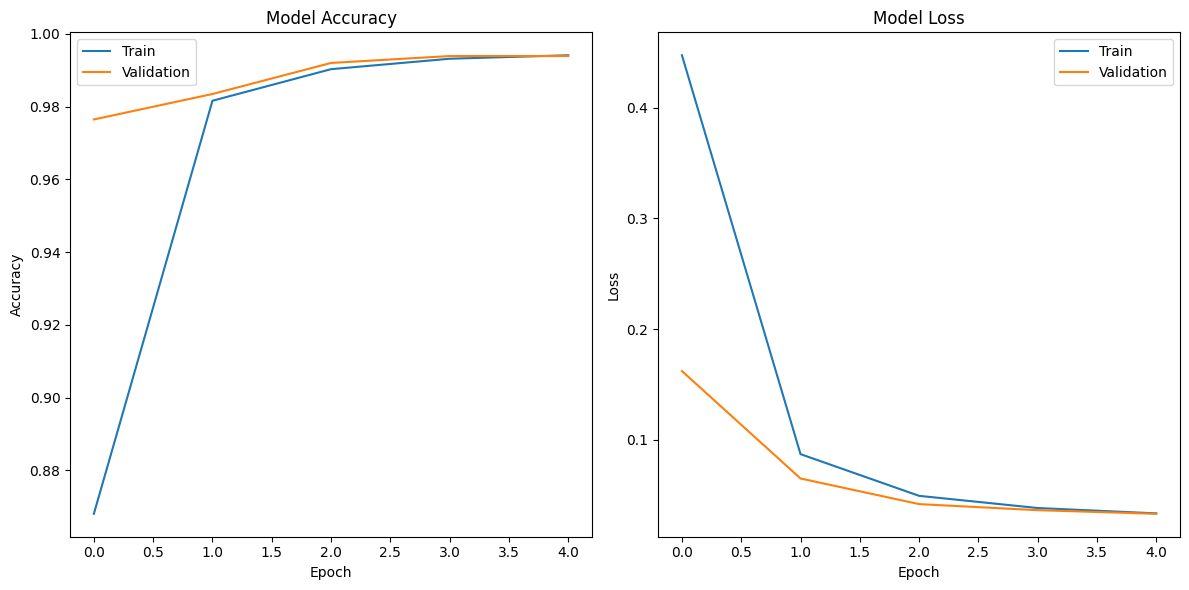

In [69]:


loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy')  
val_accuracy = history.history.get('val_accuracy')  


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


In [70]:
scores = model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))

print(f"accuracy: {scores[1] * 100}")

24/24 [==============================] - 5s 228ms/step - loss: 0.0336 - accuracy: 0.9936 - ignore_accuracy: 0.9480
accuracy: 99.3569016456604


In [71]:
accuracy=scores[1] * 100

In [72]:
comparison_table_add("4.1","LSTM","Default",accuracy)

## [4.2]

## [4.3]

In [73]:
df = pd.DataFrame(comparison_table)
df

,question_step_number,model_name,features,accuracy
0,2.1,default_tagger,Default,0.954692
1,2.2,Lookup Tagger,Default,0.534698
2,2.2,Lookup Tagger,backoff: default_tagger,0.967001
3,2.3,Unigram tagger,Default,0.938369
4,2.3,bigram tagger,backoff: DefaultTagger,0.975493
5,3.2,Multinomial naive bayes,[diac],0.953367
6,3.2,Multinomial naive bayes,"[diac, lex]",0.957527
7,3.2,Multinomial naive bayes,"[diac, lex, root]",0.955607
8,3.2,Multinomial naive bayes,"[diac, lex, root, prefix-1]",0.955607
9,3.2,Multinomial naive bayes,"[diac, lex, root, prefix-1, prefix-2]",0.954967
